# **COMPUTER VISION PROJECT - FACE RECOGNITION**

> Dataset: Large-scale CelebFaces Attributes

> Objective: Creating a computer vision model for gender detection using GoogLeNet architechture (InceptionV3).

> Reference:
1. https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
2. https://www.kaggle.com/code/dpamgautam/face-recognition-gender-detection-inceptionv3
3. https://www.kaggle.com/code/nageshsingh/gender-detection-using-inceptionv3-92-6-acc
4. https://www.kaggle.com/code/lusfernandotorres/gender-recognition-inceptionv3
5. https://github.com/ndb796/CelebA-HQ-Face-Identity-and-Attributes-Recognition-PyTorch/blob/main/CelebAMask_HQ_Dataset_Processing.ipynb
6. https://github.com/ritika-0111/Gender-Detection-with-Inception-V3/blob/main/gender-classification-with-inceptionv3.ipynb

## **IMPORT LIBRARY**

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam

from PIL import Image

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **DATA PREPARATION AND EXPLORATION**

In [ ]:
data_path = '/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition'

In [ ]:
os.listdir(data_path)

['class_identity.txt',
 'gender_classification.csv',
 'list_attribute.txt',
 'gender_classification.xlsx',
 'Images',
 'list_attribute_edited.txt',
 'data_filtered.txt',
 'data_filtered_gender.txt',
 'Face_Recognition_Amar Version 2.ipynb',
 'Face_Recognition_Amar Version 1.ipynb']

In [ ]:
# load the raw data
list_att = pd.read_csv(data_path+'/list_attribute_edited.txt', delimiter=' ', skipinitialspace=True)
list_att.drop(columns=['Unnamed: 41'], inplace=True)
list_att.replace(to_replace=-1, value=0, inplace=True)
list_att

,Image_Id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
202595,202596.jpg,0,0,0,0,0,1,1,0,0,...,0,1,1,0,0,0,0,0,0,1
202596,202597.jpg,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
202597,202598.jpg,0,1,1,0,0,0,1,0,1,...,0,1,0,1,1,0,1,0,0,1


In [ ]:
# list of available attributes
for i, j in enumerate(list_att.columns):
  print(i, j)

0 Image_Id
1 5_o_Clock_Shadow
2 Arched_Eyebrows
3 Attractive
4 Bags_Under_Eyes
5 Bald
6 Bangs
7 Big_Lips
8 Big_Nose
9 Black_Hair
10 Blond_Hair
11 Blurry
12 Brown_Hair
13 Bushy_Eyebrows
14 Chubby
15 Double_Chin
16 Eyeglasses
17 Goatee
18 Gray_Hair
19 Heavy_Makeup
20 High_Cheekbones
21 Male
22 Mouth_Slightly_Open
23 Mustache
24 Narrow_Eyes
25 No_Beard
26 Oval_Face
27 Pale_Skin
28 Pointy_Nose
29 Receding_Hairline
30 Rosy_Cheeks
31 Sideburns
32 Smiling
33 Straight_Hair
34 Wavy_Hair
35 Wearing_Earrings
36 Wearing_Hat
37 Wearing_Lipstick
38 Wearing_Necklace
39 Wearing_Necktie
40 Young


In [ ]:
# making gender dataframe
gender = list_att[['Image_Id','Male']]
gender.set_index('Image_Id', inplace=True)
gender

,Male
Image_Id,
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,0
202596.jpg,1
202597.jpg,1


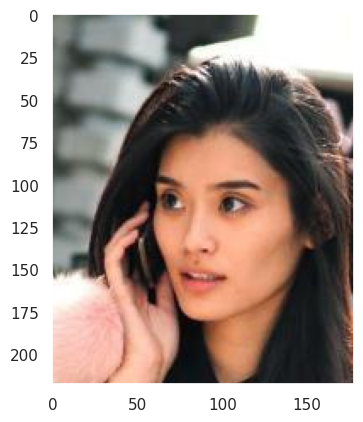

Male    0
Name: 002427.jpg, dtype: int64

In [ ]:
# displaying example picture and 'Male' column label
example_pic = '/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/Images/002427.jpg'
img = mpimg.imread(example_pic)
imgplot = plt.imshow(img)
plt.grid(False)
plt.show()
gender.loc[example_pic.split('/')[-1]][['Male']]

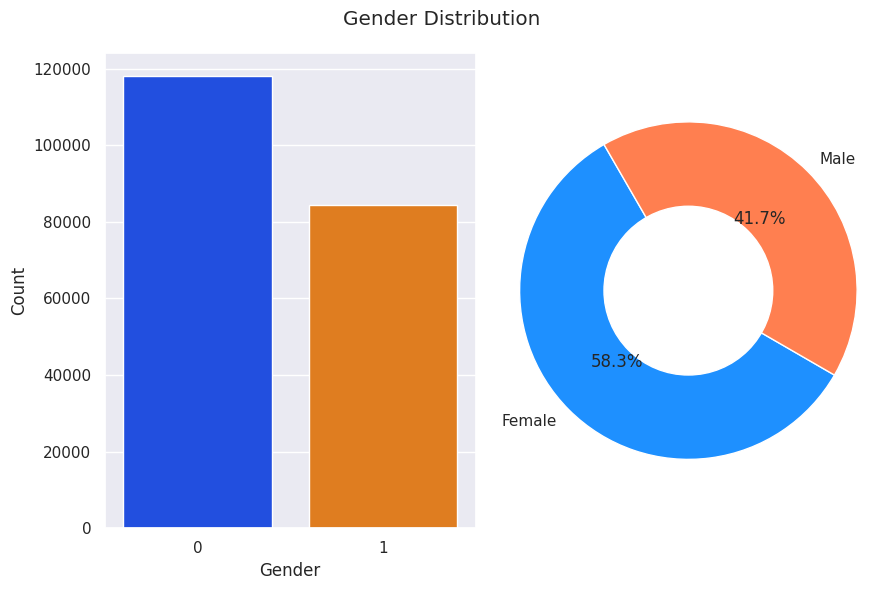

In [ ]:
# look the gender distribution
plt.figure(figsize=(9,6))

# subplot 1: countplot
plt.subplot(1, 2, 1)
sns.countplot(data=gender, x='Male', palette='bright')
plt.xlabel('Gender')
plt.ylabel('Count')

# subplot 2: pieplot
plt.subplot(1, 2, 2)
gender_count = gender['Male'].value_counts()
plt.pie(gender_count, labels=['Female', 'Male'], autopct='%1.1f%%', startangle=120, colors=['dodgerblue', 'coral'])
center_circle = plt.Circle((0,0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.suptitle('Gender Distribution')

plt.axis('equal')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/gender_distribution.png')
plt.show()

# this distribution is assumed to be balanced because the difference is still small (58% - 42%)
# assumed the imbalance data if the distribution have large difference, i.e. 70% - 30%, 75% - 25%, 80% - 20%, etc

In [ ]:
# filter the data with available images only (in this case we only have 5000 images)
images_list = os.listdir(data_path+'/Images')
avail_img = [img for img in images_list if img in list_att['Image_Id'].tolist()]
data_filtered = list_att[list_att['Image_Id'].isin(avail_img)].reset_index(drop=True).iloc[:5000]

In [ ]:
# dataset filtered gender
data_filtered_gender = data_filtered[['Image_Id', 'Male']]
data_filtered_gender.head(10)

,Image_Id,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0
5,000201.jpg,0
6,000240.jpg,0
7,000282.jpg,1
8,000352.jpg,1
9,000409.jpg,1


In [ ]:
# count female (0) and male (1)
print(f"Number of Female : {data_filtered_gender['Male'].value_counts()[0]}")
print(f"Number of Male   : {data_filtered_gender['Male'].value_counts()[1]}")

Number of Female : 2953
Number of Male   : 2047


In [ ]:
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data_filtered_gender, test_size=0.2, random_state=42)
print('Data Training: ', len(train_data))
print('Data Testing: ', len(test_data))

Data Training:  4000
Data Testing:  1000


In [ ]:
# split test data to validation data and testing data with a 50:50 ratio
val_data, testing_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [ ]:
# composition of dataset, so the composistion of data training,
#validation, and testing is 80%, 10%, 10% respectively
print('Data Training: ', len(train_data))
print('Data Validation: ', len(val_data))
print('Data Testing: ', len(testing_data))

Data Training:  4000
Data Validation:  500
Data Testing:  500


## **PRE-PROCESSING IMAGES - DATA AUGMENTATION**

In [ ]:
# datagen - generate image generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# load one image and reshape
img = load_img(example_pic)
x = img_to_array(img)/255.
x = x.reshape((1,)+x.shape)

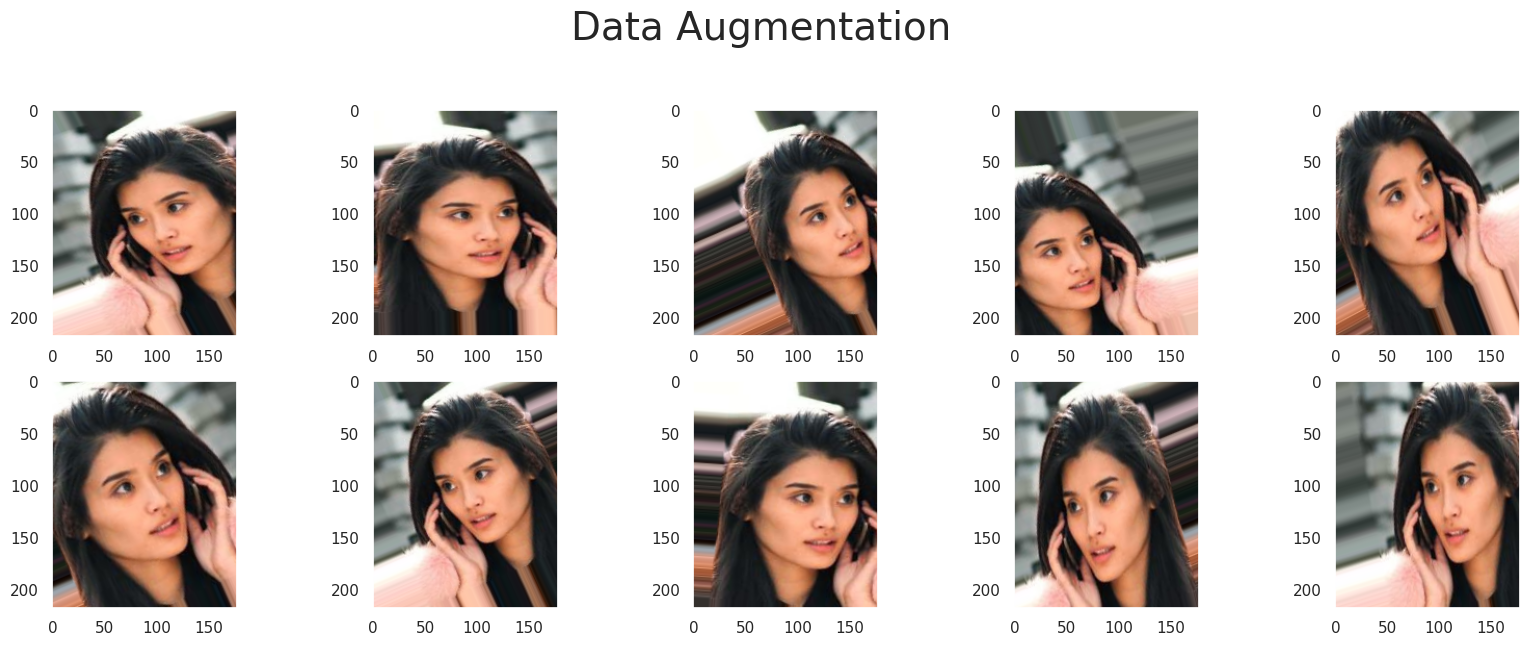

In [ ]:
# displaying 10 augmented images of the loaded image
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.subplot(3, 5, i+1)
  plt.grid(False)
  plt.imshow(batch.reshape(218, 178, 3))

  if i == 9:
    break
  i += 1

plt.show()

# ImageDataGenerator class allows your model to receive new variations of the images at each epoch,
# but do remember that it only returns the transformed images and does not add it to the set of images that you have

## **BUILD DATA GENERATORS**

In [ ]:
# data generator for data training
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# data generator for data validation
datagen_val = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)

# data generator for data testing
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)

In [ ]:
train_gen = datagen_train.flow_from_dataframe(
    dataframe=train_data,
    directory='/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/Images/',
    x_col='Image_Id',
    y_col='Male',
    batch_size=32,
    class_mode='raw',
    target_size=(178, 218),
    validate_filenames=False
)

# prepare data validation using data generator which is taken from image directory
val_gen = datagen_val.flow_from_dataframe(
    dataframe=val_data,
    directory='/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/Images/',
    x_col='Image_Id',
    y_col='Male',
    batch_size=32,
    class_mode='raw',
    target_size=(178, 218),
    validate_filenames=False
)

# prepare data testing using data generator which is taken from image directory
test_gen = datagen_test.flow_from_dataframe(
    dataframe=testing_data,
    directory='/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/Images/',
    x_col='Image_Id',
    y_col='Male',
    batch_size=32,
    class_mode='raw',
    target_size=(178, 218),
    validate_filenames=False,
    shuffle=False
)

Found 4000 non-validated image filenames.
Found 500 non-validated image filenames.
Found 500 non-validated image filenames.


## **BUILD THE MODEL**

### Define model

In [ ]:
# build base model using googlenet - inceptionv3 with imagenet weight
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(178, 218, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# lock initial layers to do not be trained
for layer in base_model.layers[:52]:
    layer.trainable = False

In [ ]:
print("Number of Layers:", len(base_model.layers))

Number of Layers: 311


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 178, 218, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 88, 108, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 88, 108, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 88, 108, 32)          0         ['batch_normalizati

### Adding top layer

In [ ]:
# adding custom layer, global average pooling layer,
# and prediction layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)
x = Flatten()(x)
predictions = Dense(1, activation="sigmoid")(x)

# merge model
model = Model(inputs=base_model.input,
              outputs=predictions)

### Compile model

In [ ]:
# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Train model

In [ ]:
# https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.det.gen.hdf5',
                               verbose=1, save_best_only=True)

# train the model
hist = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpointer],
    verbose=1
)

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.6130
Epoch 1: val_loss improved from inf to 276.46695, saving model to weights.best.det.gen.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 1075s 8s/step - loss: 0.6583 - accuracy: 0.6130 - val_loss: 276.4669 - val_accuracy: 0.6020
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.7003
Epoch 2: val_loss improved from 276.46695 to 12.77357, saving model to weights.best.det.gen.hdf5
125/125 [==============================] - 55s 437ms/step - loss: 0.5727 - accuracy: 0.7003 - val_loss: 12.7736 - val_accuracy: 0.6020
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.7920
Epoch 3: val_loss improved from 12.77357 to 0.55747, saving model to weights.best.det.gen.hdf5
125/125 [==============================] - 56s 445ms/step - loss: 0.4389 - accuracy: 0.7920 - val_loss: 0.5575 - val_accuracy: 0.7980
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8420
Epoch 4: val_loss did not improve from 0.55747
125/125 [==============================] - 53s 427ms/step - loss: 0.3

### Evaluate model

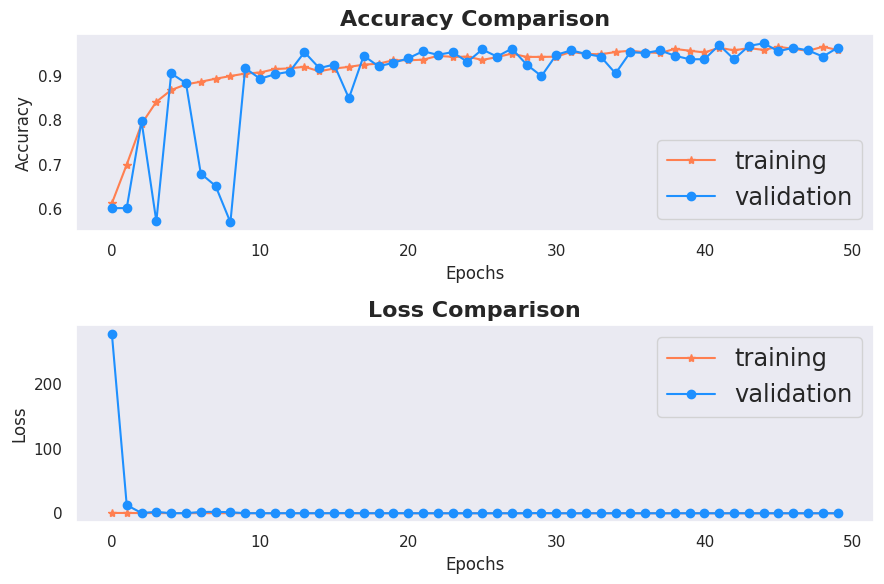

In [ ]:
# the visualization result
sns.set_theme()
def visualize_training(history, lw = 1.5):
    plt.figure(figsize=(9, 6))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw, color='coral')
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw, color='dodgerblue')
    plt.title('Accuracy Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(False)
    plt.legend(fontsize = 'x-large')

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw, color='coral')
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw, color='dodgerblue')
    plt.title('Loss Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/training_result.png')
    plt.show()

visualize_training(hist)

16/16 [==============================] - 119s 8s/step
Classification Reports: 
              precision    recall  f1-score   support

      Female       0.92      0.99      0.96       295
        Male       0.99      0.88      0.93       205

    accuracy                           0.95       500
   macro avg       0.96      0.94      0.95       500
weighted avg       0.95      0.95      0.95       500


Confusion Matrix:
[[293   2]
 [ 24 181]]



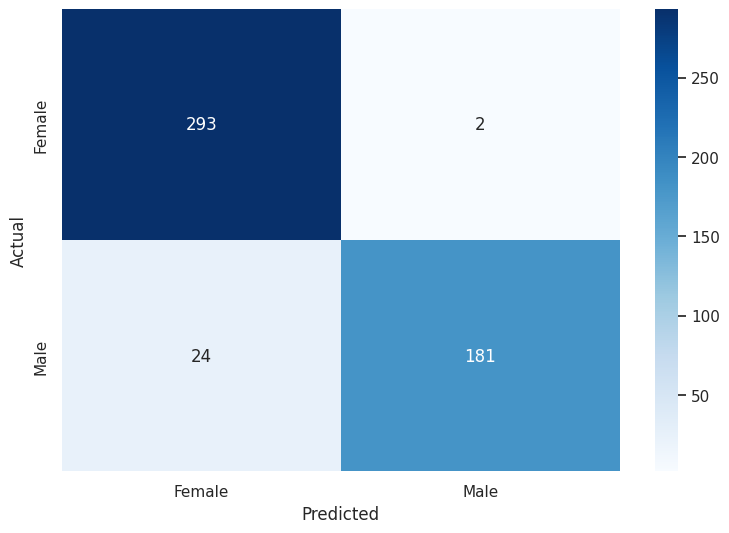

In [ ]:
#load the best model
model.load_weights('weights.best.det.gen.hdf5')

# evaluate the model
y_pred = model.predict(test_gen)
y_pred = np.array(y_pred > 0.5).astype(int).flatten()
y_true = test_gen.labels

print("Classification Reports: ")
print(classification_report(y_true, y_pred, target_names=['Female', 'Male']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/confusion_matrix.png')
plt.show()

In [ ]:
y_true

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,

In [ ]:
y_pred

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,